# Notebook 11: Target Variable Analysis

## Purpose
Deep dive into the target variable (presence/absence) and class balance to inform modeling decisions.

## Key Questions
- What is the target variable and how is it encoded?
- Is there class imbalance that requires special handling?
- Are there temporal or spatial patterns in presence?
- Which features show strongest separation between presence/absence?
- What baseline performance should we expect?

## Key Observations to Look For
- **Class Balance**: Imbalance >80/20 requires resampling (addressed via `scale_pos_weight` in XGBoost)
- **Temporal Patterns**: Presence rate by month/year, including rut phase patterns (September-October)
- **Spatial Patterns**: Hotspots and cold spots (addressed via spatial cross-validation: leave-one-region-out)
- **Feature Separation**: Features with clear presence/absence differences
- **Baseline Performance**: Minimum bar for ML models
- **Model Training Enhancements**: Current model uses spatial cross-validation, early stopping, threshold optimization, and regularization for better generalization


In [1]:
# Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set random seed
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Determine project root and output directories
possible_roots = [
    Path('.'),  # If running from project root
    Path('..'),  # If running from notebooks directory
    Path('../..'),  # If running from subdirectory
]

data_root = None
for root in possible_roots:
    if (root / 'data' / 'features').exists():
        data_root = root / 'data'
        break

if data_root is None:
    data_root = Path('../data')

# Create output directories relative to project root
figures_dir = data_root / 'figures'
reports_dir = data_root / 'reports'
figures_dir.mkdir(parents=True, exist_ok=True)
reports_dir.mkdir(parents=True, exist_ok=True)

print(f'✓ Setup complete')
print(f'  Output directory: {data_root.absolute()}')


✓ Setup complete
  Output directory: /Users/jongalentine/Projects/pathwild/notebooks/../data


## 1. Identify Target Variable

The target variable (presence/absence) is the outcome we're trying to predict. This section identifies the target column and examines its encoding and distribution.

### What to Look For
- Confirm target column is detected (elk_present, presence, or similar)
- Verify binary encoding (0/1 or True/False)
- Note total sample size for power considerations

In [2]:
# Load data
from pathlib import Path

# Try multiple possible paths
possible_paths = [
    Path('data/features/complete_context.csv'),  # From project root
    Path('../data/features/complete_context.csv'),  # From notebooks directory
    Path('../../data/features/complete_context.csv'),  # From subdirectory
]

data_path = None
for path in possible_paths:
    if path.exists():
        data_path = path
        break

if data_path is None:
    raise FileNotFoundError(
        f'Data file not found. Tried: {[str(p) for p in possible_paths]}\n'
        f'Please run: python scripts/combine_feature_files.py\n'
        f'Or ensure you are running the notebook from the project root directory.'
    )

print(f'Loading data from: {data_path}')
df = pd.read_csv(data_path)

# Automatically detect target column
target_col = None
for col in df.columns:
    if col.lower() in ['presence', 'target', 'label', 'is_presence', 'elk_present']:
        target_col = col
        break

if target_col:
    print(f'Found target column: {target_col}')
    print(f'\nUnique values: {df[target_col].unique()}')
    print(f'\nValue counts:')
    print(df[target_col].value_counts().sort_index())
    print(f'\nValue counts (normalized):')
    print(df[target_col].value_counts(normalize=True).sort_index() * 100)
    
    # Check if binary
    unique_vals = sorted(df[target_col].dropna().unique())
    if len(unique_vals) == 2:
        print(f'\n✓ Binary classification target detected')
        print(f'  Classes: {unique_vals}')
    else:
        print(f'\n⚠ Target has {len(unique_vals)} unique values (not binary)')
else:
    print('⚠ No target column detected. Looking for binary columns...')
    # Look for binary columns
    binary_cols = []
    for col in df.columns:
        unique_vals = df[col].dropna().unique()
        if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1, True, False, '0', '1'}):
            binary_cols.append(col)
    
    if len(binary_cols) > 0:
        print(f'Found potential binary columns: {binary_cols}')
        target_col = binary_cols[0]
        print(f'Using: {target_col}')
    else:
        print('⚠ No clear target variable found. This notebook focuses on binary classification.')
        target_col = None


Loading data from: ../data/features/complete_context.csv
Found target column: elk_present

Unique values: [1 0]

Value counts:
elk_present
0    204564
1    227298
Name: count, dtype: int64

Value counts (normalized):
elk_present
0    47.367909
1    52.632091
Name: proportion, dtype: float64

✓ Binary classification target detected
  Classes: [0, 1]


## 2. Class Balance Analysis

Class imbalance is one of the most important considerations for binary classification. This section quantifies the balance between presence and absence observations and determines if special handling is needed.

### What This Code Does
- Counts presence and absence observations
- Calculates class percentages and imbalance ratio
- Creates pie and bar chart visualizations
- Provides recommendations based on imbalance severity

### Understanding Class Imbalance

**Imbalance Ratio:**
The ratio of majority to minority class (e.g., 2:1 means twice as many of one class)

**Imbalance Thresholds:**
- **< 2:1**: Balanced - no special handling needed
- **2:1 to 4:1**: Moderate - consider class weights
- **4:1 to 10:1**: Severe - use resampling or specialized algorithms
- **> 10:1**: Extreme - may need anomaly detection approach

### What to Look For
- **~50/50 split**: Ideal for standard ML algorithms
- **60/40 to 70/30**: Still workable with class weights
- **>80/20**: Accuracy becomes misleading metric
- **Pseudo-absence ratio**: Should match study design (often 1:1 or 1:2)

### Implications for Modeling

**If Imbalanced:**
1. **Use F1-score** instead of accuracy as primary metric
2. **Apply class weights** in model training
3. **Consider SMOTE** oversampling of minority class
4. **Use stratified** train/test split to maintain ratio

**Elk Ecology Context:**
In habitat studies, 1:1 presence:absence ratio is common by design (one pseudo-absence per presence). Higher absence ratios (1:2 or 1:3) are sometimes used to better characterize "available" habitat. The ratio reflects study design choices, not natural occurrence rates.

Class balance:
  Class 0: 204,564 (47.4%)
  Class 1: 227,298 (52.6%)

Imbalance ratio: 1.11:1
✓ Classes are relatively balanced (1.1:1)


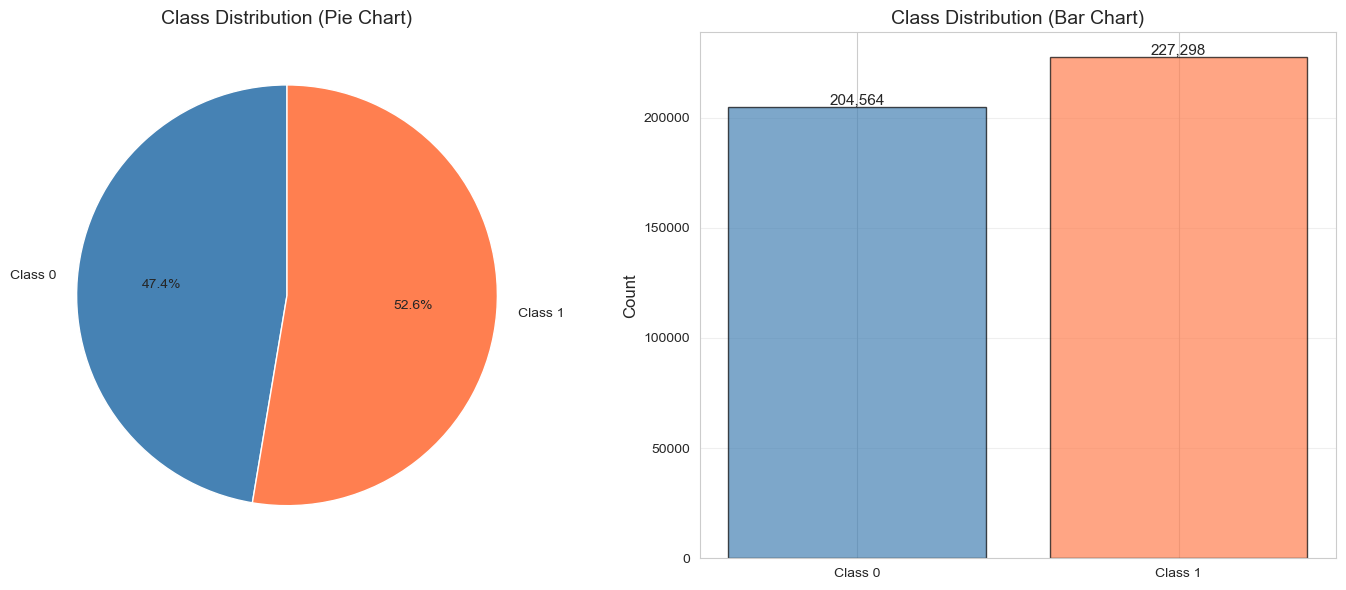


✓ Saved class balance visualizations


In [3]:
# Analyze class balance
if target_col:
    class_counts = df[target_col].value_counts().sort_index()
    class_pcts = df[target_col].value_counts(normalize=True).sort_index() * 100
    
    print('Class balance:')
    for val, count in class_counts.items():
        pct = class_pcts[val]
        print(f'  Class {val}: {count:,} ({pct:.1f}%)')
    
    # Check for imbalance
    min_pct = class_pcts.min()
    max_pct = class_pcts.max()
    imbalance_ratio = max_pct / min_pct if min_pct > 0 else np.inf
    
    print(f'\nImbalance ratio: {imbalance_ratio:.2f}:1')
    
    if imbalance_ratio > 4:  # 80/20 split
        print(f'⚠ CRITICAL: Severe class imbalance detected ({imbalance_ratio:.1f}:1)')
        print('  Recommendation: Use resampling (SMOTE, undersampling) or class weights')
    elif imbalance_ratio > 2:  # 67/33 split
        print(f'⚠ WARNING: Moderate class imbalance ({imbalance_ratio:.1f}:1)')
        print('  Recommendation: Consider class weights in model training')
    else:
        print(f'✓ Classes are relatively balanced ({imbalance_ratio:.1f}:1)')
    
    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie chart
    axes[0].pie(class_counts.values, labels=[f'Class {x}' for x in class_counts.index],
                autopct='%1.1f%%', startangle=90, colors=['steelblue', 'coral'])
    axes[0].set_title('Class Distribution (Pie Chart)', fontsize=14)
    
    # Bar chart
    axes[1].bar(range(len(class_counts)), class_counts.values, 
                color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
    axes[1].set_xticks(range(len(class_counts)))
    axes[1].set_xticklabels([f'Class {x}' for x in class_counts.index])
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title('Class Distribution (Bar Chart)', fontsize=14)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, (val, count) in enumerate(class_counts.items()):
        axes[1].text(i, count, f'{count:,}', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'class_balance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\n✓ Saved class balance visualizations')
else:
    print('⚠ Cannot analyze class balance without target column')


## 3. Presence Patterns by Time

Temporal patterns in presence rate may indicate data collection biases or real ecological patterns. This section analyzes how presence rate varies by month and year.

### What This Code Does
- Calculates presence rate (% presence) for each month
- Calculates presence rate for each year
- Creates line plots showing temporal trends

### Interpreting Temporal Presence Patterns

**Expected Pattern (for balanced pseudo-absences):**
- Presence rate should be roughly constant (~50%) across months
- If pseudo-absences are matched to presence months, this is expected

**Concerning Patterns:**
- **Monthly variation >10%**: May indicate seasonal data collection bias
- **Year-over-year trend**: May indicate population change or changing study effort
- **Single month spike**: May indicate data entry error or special collection event

### What to Look For

**Monthly Pattern:**
- **Constant ~50%**: Good - balanced sampling across seasons
- **Summer peak**: More presence data collected in summer (access?)
- **Winter peak**: More presence data collected in winter (concentration areas?)
- **Hunting season dip (Sep-Nov)**: Possible elk behavior change affecting collar data

**Yearly Pattern:**
- **Stable across years**: Good temporal generalization expected
- **Increasing trend**: Growing dataset or population
- **Decreasing trend**: Declining coverage or population
- **Missing years**: Gaps in data collection

### Elk Ecology Context
Seasonal variation in presence rate is NOT the same as seasonal variation in elk presence probability. The rate here reflects data collection, not ecology. However:
- Higher presence rates when elk are concentrated (winter) may be expected
- Lower presence rates when elk are dispersed (summer) may be expected
- True seasonal behavior is captured in environmental features, not presence rate

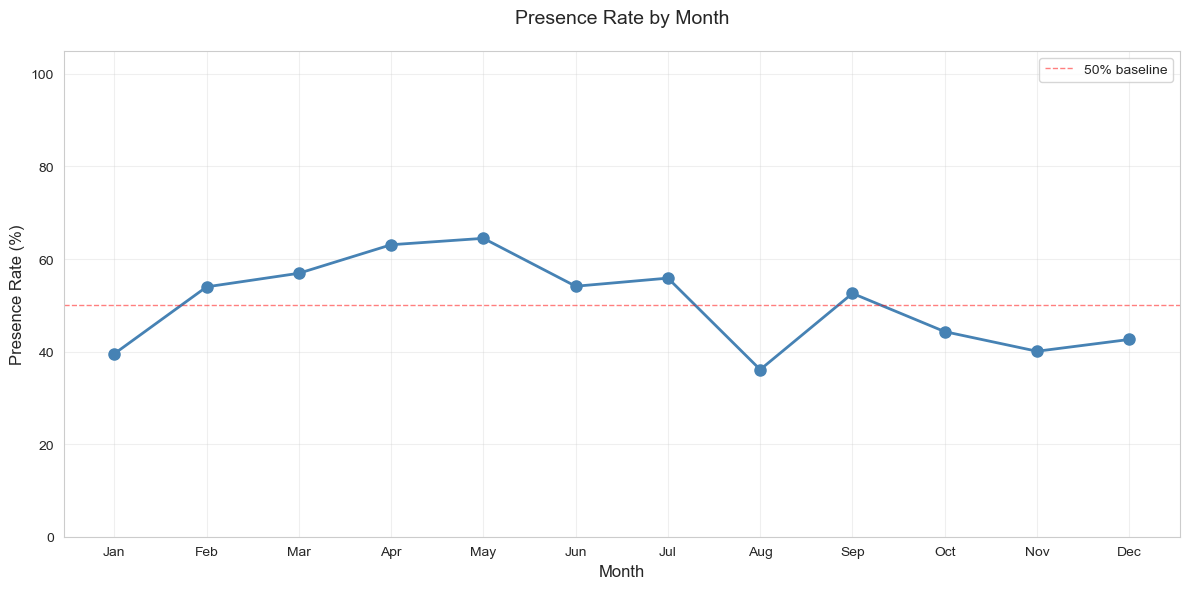


Presence rate by month:
       presences  total  presence_rate_pct
month                                     
1.0        10267  25967          39.538645
2.0         9820  18188          53.991643
3.0        15778  27717          56.925353
4.0        33130  52511          63.091543
5.0        38232  59297          64.475437
6.0        28821  53250          54.123944
7.0        31932  57146          55.877927
8.0         9006  24943          36.106322
9.0        13050  24820          52.578566
10.0       13811  31167          44.312895
11.0       12317  30734          40.076137
12.0       11134  26122          42.623076


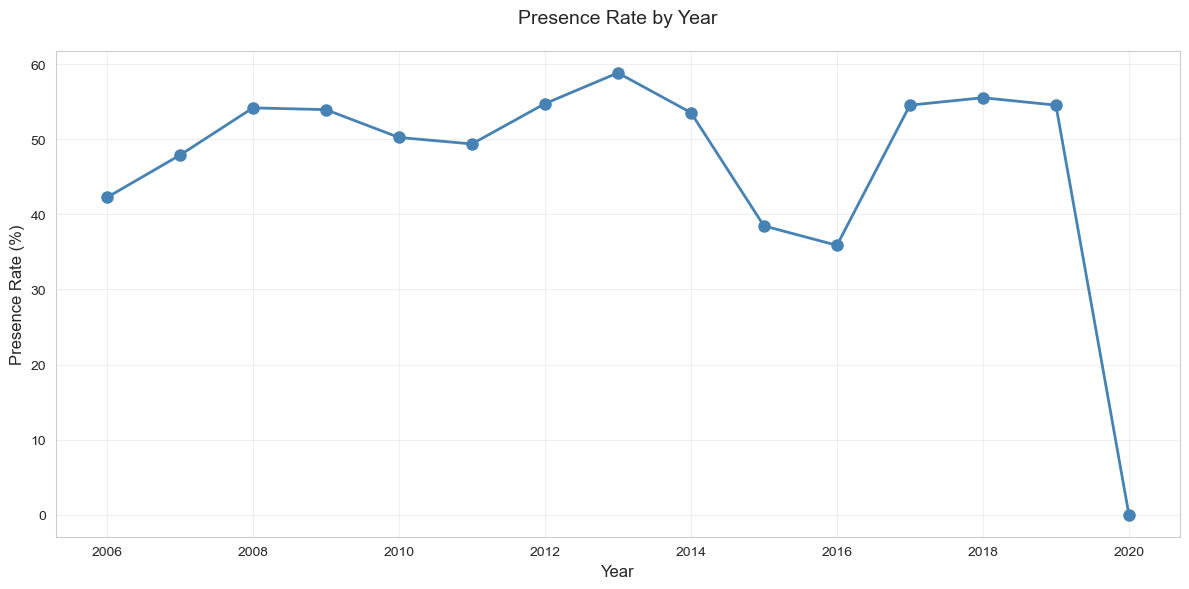


Presence rate by year:
        presences  total  presence_rate_pct
year                                       
2006.0       2608   6172          42.255347
2007.0       9372  19569          47.892074
2008.0      17448  32199          54.188018
2009.0      25648  47539          53.951492
2010.0      19931  39666          50.247063
2011.0      13684  27710          49.382894
2012.0      22971  41958          54.747605
2013.0      40586  68964          58.850995
2014.0      38053  71054          53.555043
2015.0       9203  23925          38.466040
2016.0        964   2687          35.876442
2017.0       5797  10627          54.549732
2018.0      11579  20848          55.540100
2019.0       9454  17330          54.552799
2020.0          0   1614           0.000000

### Key Observations:
  - Highest presence rate: Month 5.0 (64.5%)
  - Lowest presence rate: Month 8.0 (36.1%)

✓ Saved temporal pattern visualizations


In [4]:
# Analyze temporal patterns in presence
if target_col:
    # Check for month column
    month_col = None
    if 'month' in df.columns:
        month_col = 'month'
    
    if month_col:
        # Presence rate by month
        monthly_presence = df.groupby(month_col).agg({
            target_col: ['sum', 'count', 'mean']
        })
        monthly_presence.columns = ['presences', 'total', 'presence_rate']
        monthly_presence['presence_rate_pct'] = monthly_presence['presence_rate'] * 100
        
        plt.figure(figsize=(12, 6))
        plt.plot(monthly_presence.index, monthly_presence['presence_rate_pct'], 
                marker='o', linewidth=2, markersize=8, color='steelblue')
        plt.axhline(50, color='red', linestyle='--', linewidth=1, alpha=0.5, label='50% baseline')
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Presence Rate (%)', fontsize=12)
        plt.title('Presence Rate by Month', fontsize=14, pad=20)
        plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
        plt.ylim(0, 105)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(figures_dir / 'presence_temporal_pattern.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print('\nPresence rate by month:')
        print(monthly_presence[['presences', 'total', 'presence_rate_pct']])
        
        # Check for year column
        if 'year' in df.columns:
            yearly_presence = df.groupby('year').agg({
                target_col: ['sum', 'count', 'mean']
            })
            yearly_presence.columns = ['presences', 'total', 'presence_rate']
            yearly_presence['presence_rate_pct'] = yearly_presence['presence_rate'] * 100
            
            plt.figure(figsize=(12, 6))
            plt.plot(yearly_presence.index, yearly_presence['presence_rate_pct'], 
                    marker='o', linewidth=2, markersize=8, color='steelblue')
            plt.xlabel('Year', fontsize=12)
            plt.ylabel('Presence Rate (%)', fontsize=12)
            plt.title('Presence Rate by Year', fontsize=14, pad=20)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.savefig(figures_dir / 'presence_yearly_pattern.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print('\nPresence rate by year:')
            print(yearly_presence[['presences', 'total', 'presence_rate_pct']])
        
        print('\n### Key Observations:')
        peak_month = monthly_presence['presence_rate_pct'].idxmax()
        low_month = monthly_presence['presence_rate_pct'].idxmin()
        print(f'  - Highest presence rate: Month {peak_month} ({monthly_presence.loc[peak_month, "presence_rate_pct"]:.1f}%)')
        print(f'  - Lowest presence rate: Month {low_month} ({monthly_presence.loc[low_month, "presence_rate_pct"]:.1f}%)')
        
        if peak_month in [9, 10, 11]:  # Sep, Oct, Nov
            print('  - Peak in fall months may indicate hunting season bias')
        
        print('\n✓ Saved temporal pattern visualizations')
    else:
        print('⚠ Cannot analyze temporal patterns without month column')
else:
    print('⚠ Cannot analyze temporal patterns without target column')


## 4. Presence Patterns by Space

Spatial patterns in presence rate reveal geographic hotspots and potential spatial biases in the data. This section creates a heatmap of presence rate across the study area.

### What This Code Does
- Creates a hexbin map where color = presence rate within each hex
- Uses red-yellow-green color scale (red = low presence rate, green = high)
- Bins data into rough grid cells and calculates regional presence rates

### Interpreting Spatial Presence Patterns

**Color Scale:**
- **Green areas (high presence rate)**: Elk hotspots - core habitat
- **Yellow areas (moderate)**: Mixed use areas
- **Red areas (low presence rate)**: Elk-poor areas or well-sampled absence areas

**Expected Patterns:**
- **Heterogeneous**: Mix of colors reflecting habitat variation (good)
- **Study area clusters**: Different presence rates by region (expected)
- **Elevation bands**: Higher rates at optimal elevations

**Concerning Patterns:**
- **Uniform green**: All areas have high presence - absence generation may be flawed
- **Uniform red**: All areas have low presence - may have too many absences
- **Stark boundaries**: Artificial edges may indicate data collection artifacts

### What to Look For
- **Known elk areas**: Should show higher presence rates
- **Known poor habitat**: Should show lower presence rates
- **Winter vs summer range**: May have different presence patterns
- **Human development**: Should generally show lower presence rates

### Implications for Modeling

**Spatial Heterogeneity (good):**
- Model can learn habitat features, not just locations
- Validates that pseudo-absences create meaningful contrast

**Spatial Autocorrelation (concern):**
- Nearby locations have similar presence rates
- May need spatial cross-validation
- Consider spatial random effects in modeling

### Elk Ecology Context
Elk presence is inherently spatially clustered due to:
1. **Habitat suitability**: Some areas simply have better habitat
2. **Social behavior**: Elk are gregarious, forming herds
3. **Predator avoidance**: Certain areas provide refuge
4. **Human activity**: Elk avoid roads, development, hunting pressure

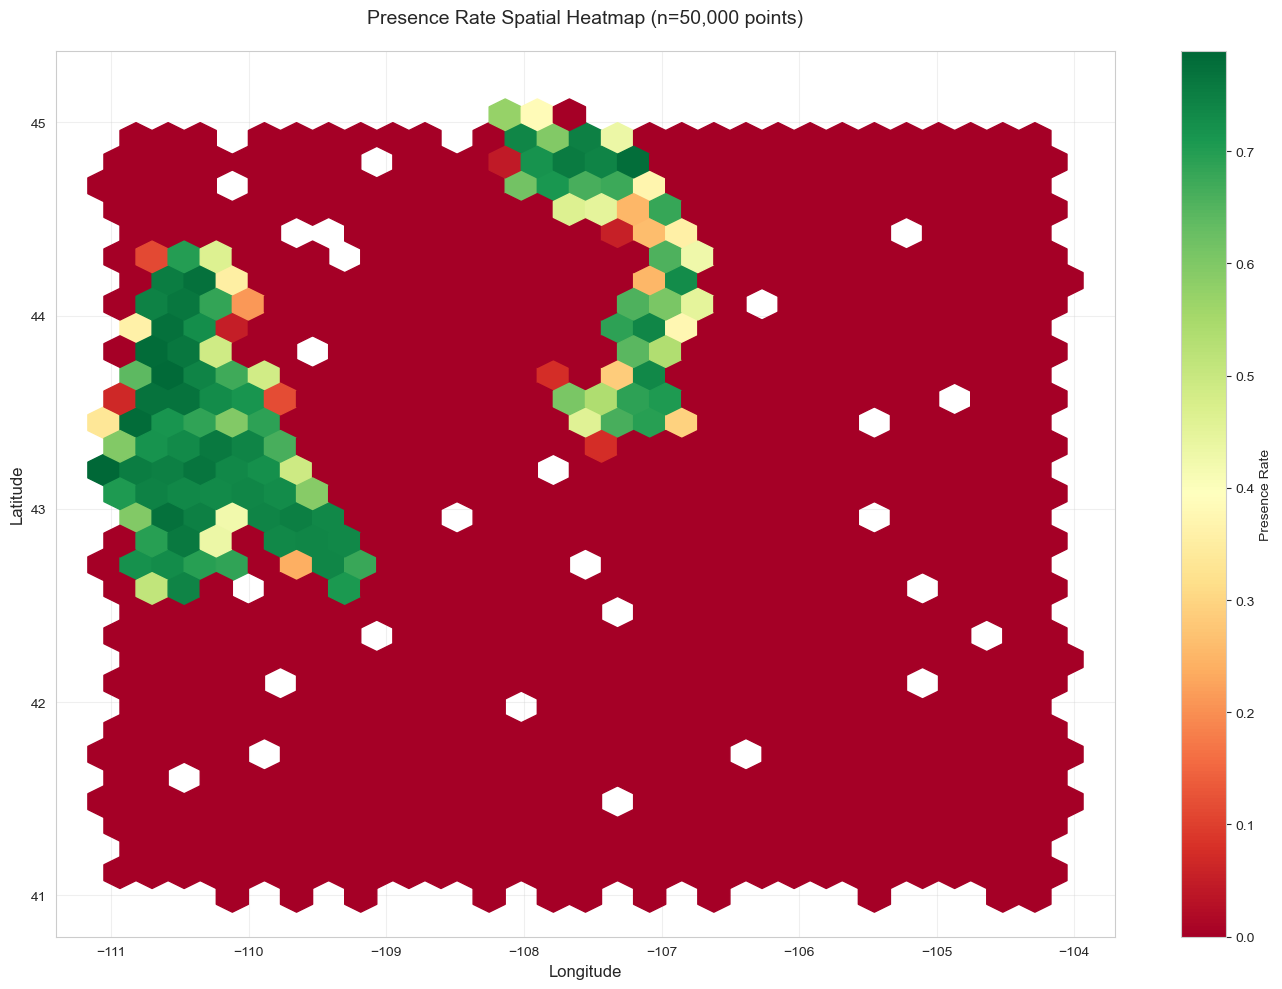

✓ Saved spatial presence pattern

### Key Observations:
  - High-presence regions (>60%): 13
  - Low-presence regions (<40%): 83
  - Spatial coverage: 363,539 unique locations


In [5]:
# Analyze spatial patterns in presence
if target_col:
    # Detect lat/lon columns
    lat_col = None
    lon_col = None
    for col in df.columns:
        if 'lat' in col.lower() and 'lon' not in col.lower():
            lat_col = col
        if 'lon' in col.lower() and 'lat' not in col.lower():
            lon_col = col
    
    if lat_col and lon_col:
        # Create hexbin map of presence rate
        plt.figure(figsize=(14, 10))
        
        # Sample if too many points
        sample_size = min(50000, len(df))
        df_sample = df.sample(n=sample_size, random_state=42)
        
        # Create hexbin plot colored by presence rate
        hb = plt.hexbin(df_sample[lon_col], df_sample[lat_col], 
                       C=df_sample[target_col], gridsize=30, cmap='RdYlGn',
                       reduce_C_function=np.mean, mincnt=10)
        
        plt.colorbar(hb, label='Presence Rate')
        plt.xlabel('Longitude', fontsize=12)
        plt.ylabel('Latitude', fontsize=12)
        plt.title(f'Presence Rate Spatial Heatmap (n={sample_size:,} points)', fontsize=14, pad=20)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(figures_dir / 'presence_spatial_pattern.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print('✓ Saved spatial presence pattern')
        
        # Calculate presence rate by region (rough grid)
        df['lat_bin'] = pd.cut(df[lat_col], bins=10, labels=False)
        df['lon_bin'] = pd.cut(df[lon_col], bins=10, labels=False)
        regional_presence = df.groupby(['lat_bin', 'lon_bin'])[target_col].agg(['mean', 'count'])
        regional_presence.columns = ['presence_rate', 'count']
        
        print('\n### Key Observations:')
        high_regions = regional_presence[regional_presence['presence_rate'] > 0.6]
        low_regions = regional_presence[regional_presence['presence_rate'] < 0.4]
        print(f'  - High-presence regions (>60%): {len(high_regions)}')
        print(f'  - Low-presence regions (<40%): {len(low_regions)}')
        print(f'  - Spatial coverage: {df[[lat_col, lon_col]].drop_duplicates().shape[0]:,} unique locations')
    else:
        print('⚠ Cannot analyze spatial patterns without lat/lon columns')
else:
    print('⚠ Cannot analyze spatial patterns without target column')


## 5. Feature Distributions: Presence vs Absence

Violin plots provide rich comparison of feature distributions between presence and absence classes, showing not just means but full distribution shapes including bimodality and outliers.

### What This Code Does
- Creates violin plots for top 12 features (by variance)
- Shows full distribution shape for each class
- Performs t-tests and calculates effect sizes (Cohen's d)
- Identifies statistically significant differences

### Interpreting Violin Plots

**Violin Shape:**
- **Width**: Indicates density of observations at that value
- **Height**: Shows full range of values
- **Widest point**: Mode (most common value)
- **Thin necks**: Values where few observations exist

**Comparing Classes:**
- **Shifted violins**: Means differ (good discrimination)
- **Different shapes**: Even with similar means, different distributions may be informative
- **Overlapping violins**: Feature has limited discriminative power

### What to Look For

**Strong Discriminators:**
- Presence and absence violins clearly separated
- Statistical test shows p < 0.01 AND |Cohen's d| > 0.5
- Direction makes ecological sense

**Weak Discriminators:**
- Violins nearly identical
- Large overlap despite statistical significance
- Cohen's d near zero

### Expected Directions (Presence vs Absence)

| Feature | Expected Direction | Ecological Reason |
|---------|-------------------|-------------------|
| NDVI | Presence higher | Better forage |
| Elevation | Presence optimal range | Thermal/forage trade-off |
| Slope | Presence lower | Energy conservation |
| Water distance | Presence lower | Water requirement |
| Road distance | Presence higher | Human avoidance |
| Snow depth | Variable by season | Movement constraint |

### Using Results for Feature Selection
- Features with clear separation: Include in model
- Features with no separation: Consider dropping
- Features with unexpected direction: Investigate data quality

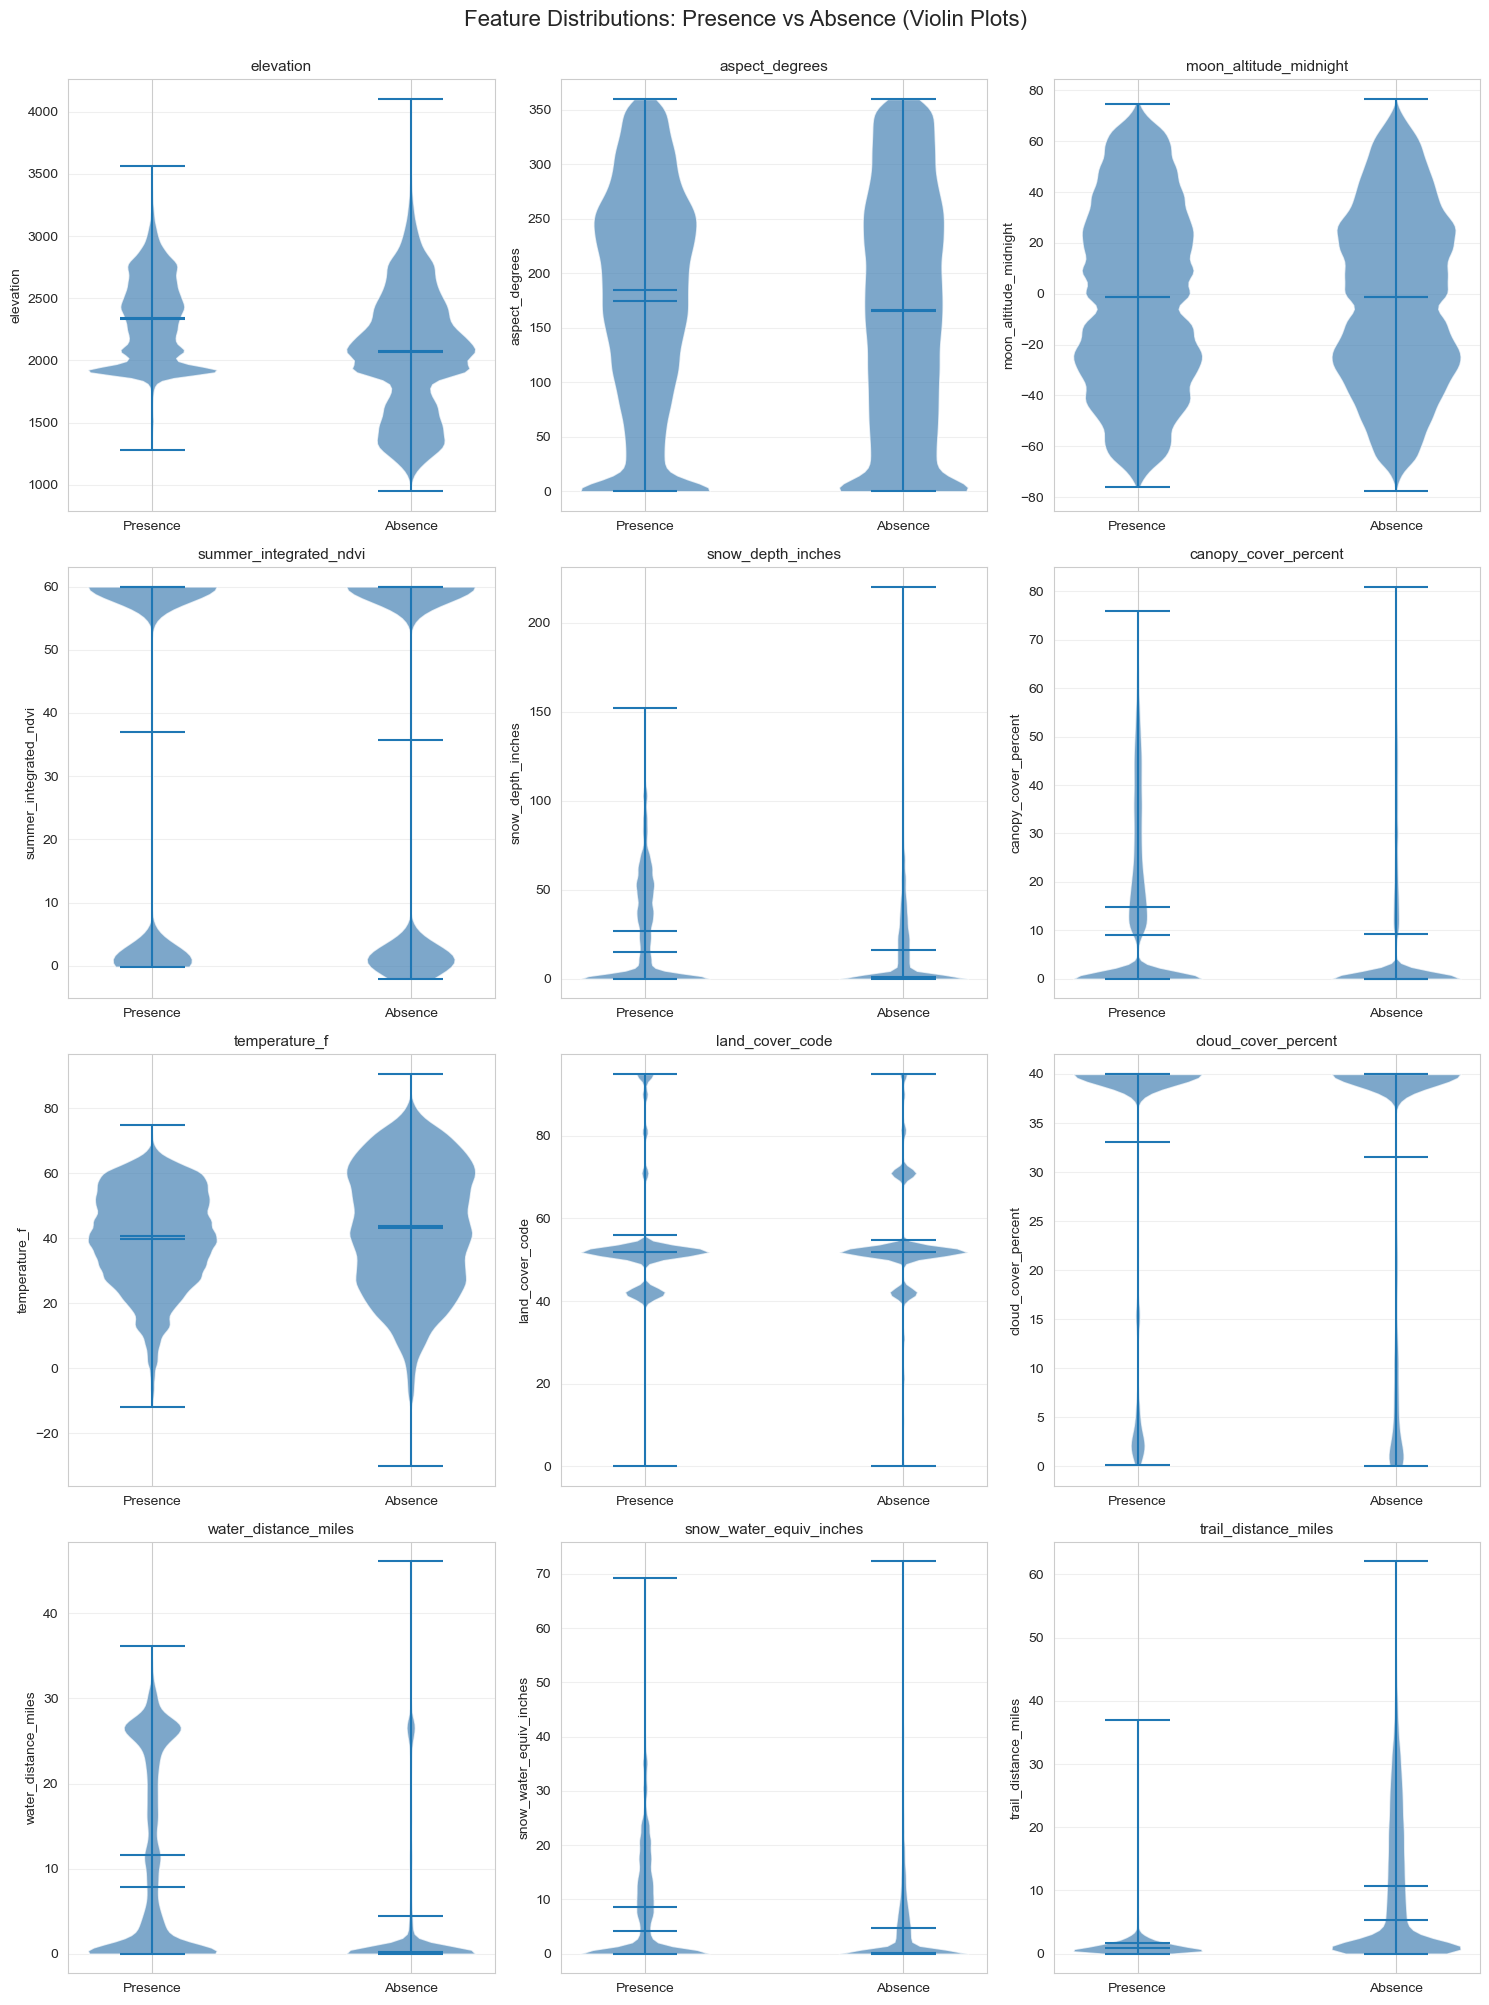

✓ Saved violin plots

### Statistical Test Results (sorted by p-value):
                    feature        p_value  cohens_d   mean_diff  significant
0                 elevation   0.000000e+00  0.632688  268.693261         True
4         snow_depth_inches   0.000000e+00  0.396268   10.841677         True
5      canopy_cover_percent   0.000000e+00  0.322249    5.650658         True
6             temperature_f   0.000000e+00 -0.194437   -3.341090         True
9      water_distance_miles   0.000000e+00  0.697232    7.110197         True
10  snow_water_equiv_inches   0.000000e+00  0.419748    3.954979         True
11     trail_distance_miles   0.000000e+00 -1.047335   -9.002731         True
8       cloud_cover_percent  6.921943e-284  0.109606    1.549427         True
1            aspect_degrees  2.855185e-177  0.086799    9.116606         True
7           land_cover_code  5.676292e-127  0.073561    1.095760         True
3    summer_integrated_ndvi   1.727336e-48  0.044592    1.291231      

In [6]:
# Create violin plots comparing presence vs absence for each feature
if target_col:
    # Get numeric columns (exclude target and index columns)
    numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns.tolist()
                   if col not in [target_col, 'point_index', 'lat_bin', 'lon_bin']]
    
    # Select top 12 features by variance
    feature_variance = df[numeric_cols].var().sort_values(ascending=False)
    top_features = feature_variance.head(12).index.tolist()
    
    n_cols = 3
    n_rows = (len(top_features) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    test_results = []
    
    for idx, col in enumerate(top_features):
        ax = axes[idx]
        
        presence_data = df[df[target_col] == 1][col].dropna()
        absence_data = df[df[target_col] == 0][col].dropna()
        
        if len(presence_data) > 0 and len(absence_data) > 0:
            # Violin plots
            data_to_plot = [presence_data, absence_data]
            parts = ax.violinplot(data_to_plot, positions=[0, 1], showmeans=True, showmedians=True)
            
            # Color violins
            for pc in parts['bodies']:
                pc.set_facecolor('steelblue')
                pc.set_alpha(0.7)
            
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['Presence', 'Absence'])
            ax.set_ylabel(col, fontsize=10)
            ax.set_title(col, fontsize=11)
            ax.grid(axis='y', alpha=0.3)
            
            # Statistical test
            t_stat, p_value = ttest_ind(presence_data, absence_data)
            mean_diff = presence_data.mean() - absence_data.mean()
            
            # Effect size (Cohen's d)
            pooled_std = np.sqrt((presence_data.std()**2 + absence_data.std()**2) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
            
            test_results.append({
                'feature': col,
                'p_value': p_value,
                'cohens_d': cohens_d,
                'mean_diff': mean_diff,
                'significant': p_value < 0.01
            })
    
    # Hide extra subplots
    for idx in range(len(top_features), len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('Feature Distributions: Presence vs Absence (Violin Plots)', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.savefig(figures_dir / 'presence_feature_violins.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('✓ Saved violin plots')
    
    # Print statistical test results
    if len(test_results) > 0:
        results_df = pd.DataFrame(test_results).sort_values('p_value')
        print('\n### Statistical Test Results (sorted by p-value):')
        print(results_df)
        
        significant = results_df[results_df['significant']]
        print(f'\n✓ {len(significant)} features show significant difference (p<0.01):')
        for _, row in significant.head(10).iterrows():
            print(f"  - {row['feature']}: p={row['p_value']:.2e}, Cohen's d={row['cohens_d']:.2f}")
else:
    print('⚠ Cannot compare feature distributions without target column')


## 6. Presence Prediction Baseline

Before building complex models, we establish baseline performance using simple strategies. Any useful model must outperform these baselines.

### What This Code Does
- **Baseline 1 (Random)**: Predicts presence/absence randomly (50/50)
- **Baseline 2 (Majority)**: Always predicts the majority class
- **Baseline 3 (Best Feature)**: Uses single best feature with threshold
- Compares accuracy, precision, recall, and F1-score

### Understanding Baselines

**Random Guess (Baseline 1):**
- Always achieves ~50% accuracy on binary classification
- Sets absolute floor for performance
- Any model worse than this is counterproductive

**Majority Class (Baseline 2):**
- If classes are 60/40, always predicting majority achieves 60%
- This is the baseline for imbalanced data
- Critical threshold for accuracy to be meaningful

**Best Single Feature (Baseline 3):**
- Uses feature with highest Cohen's d
- Threshold at median of that feature
- Shows what simple rule-based approach achieves

### What to Look For

**Baseline 2 vs Baseline 3:**
- If single feature beats majority baseline: Features have predictive power
- If similar: Features may not be discriminative enough

**Target Performance:**
- Project goal is 70%+ accuracy
- This means beating baselines by 10-20 percentage points
- For imbalanced data, focus on F1-score instead

### Setting Model Expectations

| Metric | Baseline | Target | Excellent |
|--------|----------|--------|-----------|
| Accuracy | ~50-60% | 70%+ | 80%+ |
| F1-Score | ~0.5 | 0.65+ | 0.75+ |
| AUC-ROC | 0.5 | 0.70+ | 0.80+ |

### Elk Ecology Context
Baseline performance reflects the inherent difficulty of the prediction task:
- Elk habitat selection involves many factors
- Individual variation and stochasticity add noise
- 70-80% accuracy is typical for species distribution models
- Perfect prediction is not expected (or biologically meaningful)

### Baseline Model Performance:

1. Random Guess (50/50):
   Accuracy: 0.499

2. Always Predict Majority Class (1):
   Accuracy: 0.526

3. Single Best Feature (trail_distance_miles):
   Accuracy: 0.254
   Precision: 0.141
   Recall: 0.082
   F1-Score: 0.104


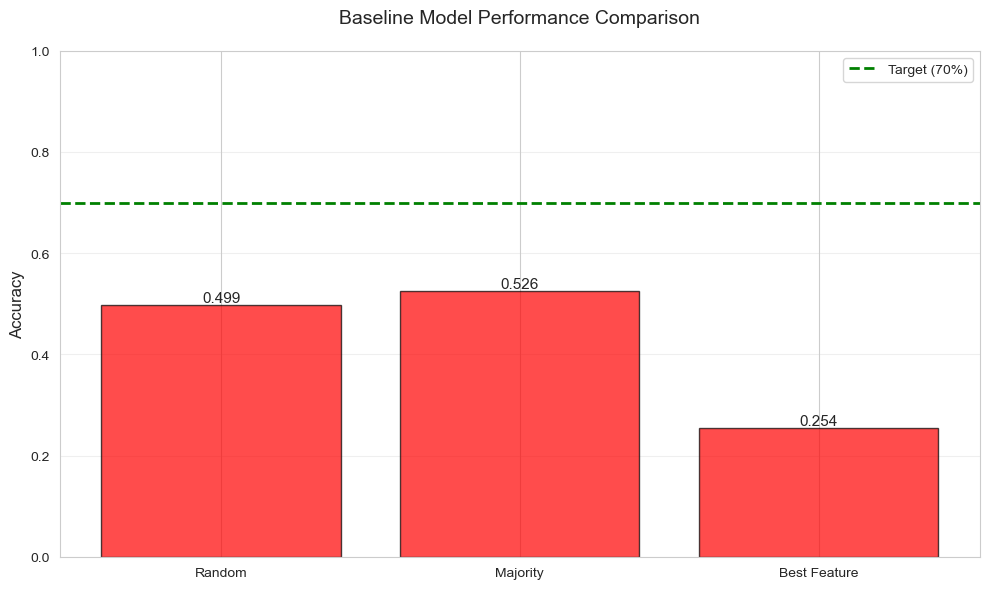


✓ Saved baseline performance comparison

### Recommendation:
  ML models must achieve >0.526 accuracy to be useful
  Target accuracy: 70%+ (as specified in project goals)


In [7]:
# Create simple baseline models
if target_col:
    y_true = df[target_col].dropna()
    
    # Baseline 1: Random guess (50/50)
    np.random.seed(42)
    y_random = np.random.randint(0, 2, size=len(y_true))
    acc_random = accuracy_score(y_true, y_random)
    
    # Baseline 2: Always predict majority class
    majority_class = y_true.mode()[0]
    y_majority = np.full(len(y_true), majority_class)
    acc_majority = accuracy_score(y_true, y_majority)
    
    # Baseline 3: Best single feature (if we have test results)
    best_feature_acc = 0
    best_feature_name = None
    if 'results_df' in locals() and len(results_df) > 0:
        # Use feature with highest |Cohen's d|
        best_feature = results_df.loc[results_df['cohens_d'].abs().idxmax(), 'feature']
        best_feature_name = best_feature
        
        # Create threshold-based classifier
        presence_data = df[df[target_col] == 1][best_feature].dropna()
        absence_data = df[df[target_col] == 0][best_feature].dropna()
        
        if len(presence_data) > 0 and len(absence_data) > 0:
            threshold = (presence_data.median() + absence_data.median()) / 2
            valid_mask = df[best_feature].notna() & df[target_col].notna()
            y_feature = (df.loc[valid_mask, best_feature] > threshold).astype(int)
            y_true_feature = df.loc[valid_mask, target_col]
            
            if len(y_feature) > 0:
                best_feature_acc = accuracy_score(y_true_feature, y_feature)
                prec_feature = precision_score(y_true_feature, y_feature, zero_division=0)
                rec_feature = recall_score(y_true_feature, y_feature, zero_division=0)
                f1_feature = f1_score(y_true_feature, y_feature, zero_division=0)
    
    # Print baseline results
    print('### Baseline Model Performance:')
    print(f'\n1. Random Guess (50/50):')
    print(f'   Accuracy: {acc_random:.3f}')
    
    print(f'\n2. Always Predict Majority Class ({majority_class}):')
    print(f'   Accuracy: {acc_majority:.3f}')
    
    if best_feature_name:
        print(f'\n3. Single Best Feature ({best_feature_name}):')
        print(f'   Accuracy: {best_feature_acc:.3f}')
        print(f'   Precision: {prec_feature:.3f}')
        print(f'   Recall: {rec_feature:.3f}')
        print(f'   F1-Score: {f1_feature:.3f}')
    
    # Create comparison bar chart
    baseline_names = ['Random', 'Majority', 'Best Feature']
    baseline_accs = [acc_random, acc_majority, best_feature_acc if best_feature_name else 0]
    
    plt.figure(figsize=(10, 6))
    colors = ['red' if x < 0.6 else 'orange' if x < 0.7 else 'green' for x in baseline_accs]
    bars = plt.bar(baseline_names, baseline_accs, color=colors, alpha=0.7, edgecolor='black')
    plt.axhline(0.7, color='green', linestyle='--', linewidth=2, label='Target (70%)')
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Baseline Model Performance Comparison', fontsize=14, pad=20)
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars, baseline_accs):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=11)
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'baseline_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print('\n✓ Saved baseline performance comparison')
    print(f'\n### Recommendation:')
    best_baseline = max(baseline_accs)
    print(f'  ML models must achieve >{best_baseline:.3f} accuracy to be useful')
    print(f'  Target accuracy: 70%+ (as specified in project goals)')
else:
    print('⚠ Cannot create baselines without target column')


## 7. Modeling Recommendations

Based on the target variable analysis, this section generates comprehensive recommendations for model development including handling class imbalance, choosing evaluation metrics, and setting up train/test splits.

### What This Code Does
- Synthesizes findings from all previous sections
- Generates prioritized recommendations by category
- Saves detailed recommendations to `data/reports/modeling_recommendations.md`

### Recommendation Categories

**Class Imbalance:**
- Based on observed imbalance ratio
- Recommends appropriate handling techniques
- Informs loss function and sampling strategy

**Train/Test Split:**
- Based on temporal patterns observed
- Recommends temporal vs random split
- Addresses potential data leakage

**Evaluation Metrics:**
- Based on class balance and use case
- Recommends primary and secondary metrics
- Sets performance thresholds

**Baseline Performance:**
- Documents baselines that models must exceed
- Sets minimum acceptable performance
- Aligns with project goals (70% accuracy)

### How to Use Recommendations

1. **Review high-priority items first** - address before training any models
2. **Set up evaluation framework** - decide metrics before comparing models
3. **Document design choices** - record rationale for future reference
4. **Iterate based on results** - adjust approach if initial models underperform

In [8]:
# Generate comprehensive modeling recommendations
if target_col:
    recommendations = []
    
    # Class imbalance recommendations
    if 'imbalance_ratio' in locals():
        if imbalance_ratio > 4:
            recommendations.append({
                'category': 'Class Imbalance',
                'issue': f'Severe imbalance ({imbalance_ratio:.1f}:1)',
                'recommendation': 'Use SMOTE oversampling or class weights in model',
                'priority': 'HIGH'
            })
        elif imbalance_ratio > 2:
            recommendations.append({
                'category': 'Class Imbalance',
                'issue': f'Moderate imbalance ({imbalance_ratio:.1f}:1)',
                'recommendation': 'Consider class weights in model training',
                'priority': 'MEDIUM'
            })
    
    # Train/test split recommendations
    if 'month_col' in locals() and month_col:
        recommendations.append({
            'category': 'Train/Test Split',
            'issue': 'Temporal data with seasonal patterns',
            'recommendation': 'Use temporal split (train on earlier years, test on later) or stratified by month',
            'priority': 'HIGH'
        })
    else:
        recommendations.append({
            'category': 'Train/Test Split',
            'issue': 'No clear temporal structure',
            'recommendation': 'Use stratified random split to maintain class balance',
            'priority': 'MEDIUM'
        })
    
    # Evaluation metrics recommendations
    if 'imbalance_ratio' in locals() and imbalance_ratio > 2:
        recommendations.append({
            'category': 'Evaluation Metrics',
            'issue': 'Class imbalance makes accuracy misleading',
            'recommendation': 'Focus on F1-score, precision, recall, and AUC-ROC instead of accuracy',
            'priority': 'HIGH'
        })
    else:
        recommendations.append({
            'category': 'Evaluation Metrics',
            'issue': 'Relatively balanced classes',
            'recommendation': 'Accuracy is acceptable, but also track F1-score and AUC-ROC',
            'priority': 'MEDIUM'
        })
    
    # Baseline performance
    if 'best_baseline' in locals():
        recommendations.append({
            'category': 'Baseline Performance',
            'issue': f'Best baseline achieves {best_baseline:.3f} accuracy',
            'recommendation': f'ML models must exceed {best_baseline:.3f} to be useful. Target: 70%+',
            'priority': 'HIGH'
        })
    
    # Save recommendations
    if len(recommendations) > 0:
        rec_df = pd.DataFrame(recommendations)
        
        print('### Modeling Recommendations:')
        print(rec_df.to_string(index=False))
        
        report = f'''# Modeling Recommendations for PathWild

Generated: {pd.Timestamp.now()}

## Summary

Based on target variable analysis, the following recommendations are provided for model development.

## Recommendations by Category

'''
        
        for category in rec_df['category'].unique():
            category_recs = rec_df[rec_df['category'] == category]
            report += f'\n### {category}\n\n'
            for _, rec in category_recs.iterrows():
                report += f'- **Priority**: {rec["priority"]}\n'
                report += f'  - **Issue**: {rec["issue"]}\n'
                report += f'  - **Recommendation**: {rec["recommendation"]}\n\n'
        
        report += '''
## Next Steps

1. Address high-priority recommendations before model training
2. Set up appropriate train/test split strategy
3. Choose evaluation metrics based on class balance
4. Establish baseline performance targets
5. Proceed with feature engineering and model selection

## Target Performance

- **Minimum**: Exceed best baseline performance
- **Target**: 70%+ accuracy (as specified in project goals)
- **Metrics**: Track accuracy, F1-score, precision, recall, and AUC-ROC
'''
        
        with open(reports_dir / 'modeling_recommendations.md', 'w') as f:
            f.write(report)
        
        print('\n✓ Saved recommendations to data/reports/modeling_recommendations.md')
    else:
        print('⚠ Could not generate recommendations')
else:
    print('⚠ Cannot generate recommendations without target column')


### Modeling Recommendations:
            category                                 issue                                                                    recommendation priority
    Train/Test Split  Temporal data with seasonal patterns Use temporal split (train on earlier years, test on later) or stratified by month     HIGH
  Evaluation Metrics           Relatively balanced classes                       Accuracy is acceptable, but also track F1-score and AUC-ROC   MEDIUM
Baseline Performance Best baseline achieves 0.526 accuracy                            ML models must exceed 0.526 to be useful. Target: 70%+     HIGH

✓ Saved recommendations to data/reports/modeling_recommendations.md


## Summary

This notebook completed a comprehensive analysis of the target variable (elk presence/absence):

### Key Findings

1. **Target Identification**: Confirmed binary target variable suitable for classification
2. **Class Balance**: Assessed imbalance ratio and recommended handling approach
3. **Temporal Patterns**: Examined presence rate variation by month/year
4. **Spatial Patterns**: Mapped presence rate hotspots and coldspots
5. **Feature Discrimination**: Identified features that separate presence from absence
6. **Baseline Performance**: Established minimum performance thresholds

### Saved Outputs

- `data/reports/modeling_recommendations.md`: Comprehensive modeling guidance
- `data/figures/class_balance.png`: Class distribution visualization
- `data/figures/presence_temporal_pattern.png`: Monthly presence rate
- `data/figures/presence_spatial_pattern.png`: Geographic presence heatmap
- `data/figures/presence_feature_violins.png`: Feature discrimination plots
- `data/figures/baseline_performance.png`: Baseline model comparison

### Next Steps

With the exploratory data analysis complete (Notebooks 06-11), you are ready to:

1. **Prepare training features** using `scripts/prepare_training_features.py`
2. **Train baseline models** starting with logistic regression and random forest
3. **Iterate on feature engineering** based on EDA insights
4. **Validate with proper cross-validation** using recommended split strategy
5. **Deploy best model** for inference pipeline

### Key Recommendations for Modeling

- Use **F1-score and AUC-ROC** as primary metrics (not just accuracy)
- Apply **stratified splits** to maintain class balance in train/test
- Consider **temporal validation** for realistic performance estimates
- Start with **top 10-15 features** identified by target correlation
- Use **tree-based models** (Random Forest, XGBoost) which handle non-linearity automatically